# Load Data
Loading Satellite data using Landsat API

## a) earthaccess

In [1]:
import earthaccess
import pandas as pd
import geopandas as gp
from pprint import pprint

auth = earthaccess.login(persist=True)
username = 'aprilianidia'
password = '28Maret1991!'

In [ ]:
roi = gp.read_file('./afg/geoBoundaries-AFG-ADM0.geojson')
bbox = tuple(list(roi.total_bounds))
bbox

In [ ]:
dataset = earthaccess.search_data(
    short_name='HLSL30',
    cloud_cover=(0,20),
    bounding_box=bbox,
    temporal=("2020-01-01T00:00:00", "2020-12-31T23:59:59"),
    count=5,
)

pd.json_normalize(dataset).head()

In [ ]:
urls = [granule.data_links() for granule in dataset]
urls[0:2]

In [ ]:
data_links = [{'links': granule.data_links(access="on_prem"), 'size (MB):' : granule.size()} for granule in dataset]
data_links

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

browse_urls = [granule.dataviz_links()[0] for granule in dataset]

image = io.imread(browse_urls[2])
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [ ]:
from osgeo import gdal

gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE', '~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')

h = urls[1]
h


In [ ]:
# downloading each granules -- need in automation of this process
files = earthaccess.download(dataset, "./data/LC08/2020")

In [ ]:
evi_band_links = []

if h[0].split('/')[4] == 'HLSL30.020':
    evi_bands = ['B05', 'B04', 'B02'] # for Landsat 8
else:
    print('Please check the sensor again.')

for a in h:
    if any(b in a for b in evi_bands):
        evi_band_links.append(a)

evi_band_links

In [ ]:
import xarray as xr
import rioxarray as rxr

chunk_size = dict(band=1, x=512, y=512) 
max_retries = 10
for e in evi_band_links:
    print(e)
    for _i in range(max_retries):
        try:
            if e.rsplit('.', 2)[-2] == evi_bands[0]:     
                nir = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
                nir.attrs['scale_factor'] = 0.0001        
            elif e.rsplit('.', 2)[-2] == evi_bands[1]:    
                red = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
                red.attrs['scale_factor'] = 0.0001       
            elif e.rsplit('.', 2)[-2] == evi_bands[2]:  
                blue = rxr.open_rasterio(e, chunks=chunk_size, masked=True).squeeze('band', drop=True)
                blue.attrs['scale_factor'] = 0.0001      
            break 
        except Exception as ex:
            print(f"vsi curl error: {ex}. Retrying...")
    else:
        print(f"Failed to process {e} after {max_retries} retries. Please check to see you're authenticated with earthaccess.")
print("The COGs have been loaded into memory!")

## b) landsatxplore

In [ ]:
import landsatxplore
from landsatxplore import errors
from landsatxplore.earthexplorer import EarthExplorer
from landsatxplore.api import API

import os
import json
import pandas as pd

In [ ]:
username = "aprilianidiar"
password = "28Maret1991!100423"

api = API(username, password)

response = api.request(endpoint='dataset-catalogs')
print(response)

In [ ]:
results = []

datasets = 'landsat_tm_c2_l2'

for dataset in datasets:
    scenes = api.search(
        dataset=datasets,
        latitude=33.83,
        longitude=66.03,
        start_date='1990-01-01',
        end_date='1990-12-31',
        max_cloud_cover=20,
    )
    results.extend(scenes)

print(f"{len(scenes)} scenes found.")

In [ ]:
df_scenes = pd.DataFrame(results)
df_scenes['tier'] = [int(x[-1]) for x in df_scenes["display_id"]]
df_scenes['satellite'] = [int(str(x)[-1]) for x in df_scenes['satellite']]

df_scenes = df_scenes[['display_id', 'wrs_path', 'wrs_row', 'satellite', 'cloud_cover', 'tier', 'acquisition_date']]
df_scenes.columns = ['id', 'path', 'row', 'satellite', 'cloud_cover', 'tier', 'date']

df_scenes['year'] = pd.to_datetime(df_scenes['date']).dt.year
df_scenes['month'] = pd.to_datetime(df_scenes['date']).dt.month

df_scenes.sort_values('date', ascending=True, inplace=True)

print(df_scenes)

In [ ]:
for scene in scenes:
    print(scene['acquisition_date'].strftime('%Y-%m-%d'))
    fname = f"./data/LT05/1990/{scene['landsat_product_id']}.geojson"
    with open(fname, "w") as f:
        json.dump(scene['spatial_coverage'].__geo_interface__, f)

# Stacking Data

## 1) Read Data
Reading the data from the existing module (earthaccess/landsatxplore) which transferred into *local*.

In [ ]:
import numpy as np
import rasterio as rio

from glob import glob
from osgeo import ogr

In [ ]:
bands = glob("./data/LC08/2020/*.tif")
bands.sort()

stacked = []
for i in bands:
    with rio.open(i, 'r') as f:
        stacked.append(f.read(1))

stacked = np.stack(stacked)


In [ ]:
training = ogr.Open('./afg/afg_train.shp')
shape = training.GetLayer(0)
feature = shape.GetFeature(0)
first = feature.ExportToJson()
print(first)

## 2) Data Visualization 

In [ ]:
import earthpy.plot as ep 

ep.plot_rgb(
    stacked,
    rgb=(3,2,1), #for landsat-5
    stretch=True,
    str_clip=0.02,  
    figsize=(10,10),
    title="RGB Composite Image with Stretch Applied",
)

plt.show()

In [ ]:
ep.plot_bands(
    stacked,
    cmap='gist_earth',
    figsize=(10,10),
    cols=6,
    cbar=False
)

plt.show()

# Classification


## 1) Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

x = np.moveaxis(stacked, 0, -1)

X_data = x.reshape(-1, 12)
scaler = StandardScaler().fit(X_data)
X_scaled = scaler.transform(X_data)

# split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, 
    first.ravel(),
    test_size=0.30,
    stratify=first.ravel()
)

print(
    f"X_train Shape: {X_train.shape} \n X_test Shape: {X_test.shape} \n Y_train Shape: {Y_train.shape} \n Y_test Shape: {Y_test.shape}"
)

## 2) Classifier

### a) Using K-Nearest Neighbor Classifier (K-NNC)

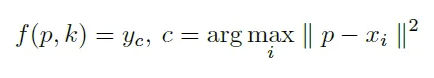

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, Y_train)

knn_pred = knn.predict(X_test)
print(f"Accuracy: {accuracy_score(Y_test, knn_pred)*100}")
print(classification_report(Y_test, knn_pred))

In [ ]:
from matplotlib.colors import ListedColormap

ep.plot_bands(knn.predict(X_scaled).reshape((954, 298)),
              cmap=ListedColormap([
                  'darkgreen',
                  'green',
                  'black',
                  '#CA6F1E',
                  'navy',
                  'forestgreen',
              ]))
plt.show()

### b) Using Support Vector Machine (SVM)
Based on the module *scikit learn*

In [ ]:
from sklearn.svm import SVC

svm = SVC(
    C=3.0,
    kernel='rbf',
    degree=6,
    cache_size=1024
)

svm.fit(X_train, Y_train)
svm_pred = svm.predict(X_test)

print(f"Accuracy: {accuracy_score(Y_test, svm_pred)*100}")
print(classification_report(Y_test, svm_pred))

In [ ]:
ep.plot_bands(svm.predict(X_scaled).reshape((954, 298)),
              cmap=ListedColormap([
                  'darkgreen',
                  'green',
                  'black',
                  '#CA6F1E',
                  'navy',
                  'forestgreen',
              ]))
plt.show()

### c) Using Gradient Boosting Classifier
Based on the module *LightGBM*

In [ ]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, label=Y_train)

params = {}
params['learning_rate']=0.03
params['boosting_type']='gbdt'
params['objective']='multiclass'
params['metric']='multi_logloss'
params['max_depth']=15
params['num_class']=6

clf = lgb.train(params, d_train, 100)

lgb_predictions = clf.predict(X_test)
lgb_pred = np.argmax(lgb_predictions, axis=1)

print(f"Accuracy: {accuracy_score(Y_test, lgb_pred)*100}")
print(classification_report(Y_test, lgb_pred))